In [1]:
import torch
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout # For the multi-perceptron layer
from torch_geometric.nn import GINConv  # Load graph isomorphism network
from torch_geometric.nn import global_mean_pool, global_add_pool
from torch_geometric.data import Data
from sklearn.metrics import accuracy_score, mean_squared_error

In [2]:
# 🧱 Define Model (GIN)
class GIN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels): # where "dim_h" is dimensionality of layer; number of features or neurons that layer processes
        super(GIN, self).__init__()
        self.conv1 = GINConv( # design of the multilayer perceptron layer for the GINConv layer based on the paper (https://arxiv.org/pdf/1905.12265)
            Sequential(Linear(in_channels, hidden_channels),
                       BatchNorm1d(hidden_channels), ReLU(),
                       Linear(hidden_channels, hidden_channels), ReLU()))
        self.conv2 = GINConv(
            Sequential(Linear(hidden_channels, hidden_channels), BatchNorm1d(hidden_channels), ReLU(),
                       Linear(hidden_channels, hidden_channels), ReLU()))
        self.conv3 = GINConv(
            Sequential(Linear(hidden_channels, hidden_channels), BatchNorm1d(hidden_channels), ReLU(),
                       Linear(hidden_channels, hidden_channels), ReLU()))
        self.lin1 = Linear(hidden_channels*3, hidden_channels*3)
        self.lin2 = Linear(hidden_channels*3, out_channels)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        # Node embeddings
        h1 = self.conv1(x, edge_index) 
        h2 = self.conv2(h1, edge_index)
        h3 = self.conv3(h2, edge_index)

        # Graph level readout
        h1 = global_add_pool(h1, batch) 
        h2 = global_add_pool(h2, batch)
        h3 = global_add_pool(h3, batch)

        # Concatenate graph embeddings
        h = torch.cat((h1, h2, h3), dim=1)

        # Classifier
        h = self.lin1(h)
        h = h.relu()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)

        return h

In [7]:
#5 fold cross-validation
task = "classification"

test_data = torch.load(f"../4_train_test_split/5fold_cv/{task}/{task}_test.pt")
average_score = 0

for fold_idx in range(5):
    #load data from fold_idx-th fold
    train_data = torch.load(f"../4_train_test_split/5fold_cv/{task}/{task}_train_fold{fold_idx}.pt")
    val_data = torch.load(f"../4_train_test_split/5fold_cv/{task}/{task}_val_fold{fold_idx}.pt")

    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=32)
    test_loader = DataLoader(test_data, batch_size=32)


    #initialize models
    if task == "classification":
        num_classes = len(set([int(data.y.item()) for data in train_data]))
        model = GIN(in_channels=train_data[0].x.size(1), hidden_channels=64, out_channels=num_classes)
        criterion = torch.nn.CrossEntropyLoss()
    else:
        model = GIN(in_channels=train_data[0].x.size(1), hidden_channels=64, out_channels=1)
        criterion = torch.nn.MSELoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # 🏋️ Training loop
    def train():
        model.train()
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            out = model(batch)
            loss = criterion(out.squeeze(), batch.y if task == "regression" else batch.y.long())
            loss.backward()
            optimizer.step()

    # 📈 Evaluation
    def evaluate(loader):
        model.eval()
        preds, labels = [], []
        with torch.no_grad():
            for batch in loader:
                batch = batch.to(device)
                out = model(batch)
                preds.append(out.squeeze().cpu())
                labels.append(batch.y.cpu())
        preds = torch.cat(preds)
        labels = torch.cat(labels)

        if task == "classification":
            pred_classes = preds.argmax(dim=1)
            return accuracy_score(labels, pred_classes)
        else:
            return mean_squared_error(labels, preds)


    # training & evaluation
    for epoch in range(1, 101):
        train()
        metric = evaluate(val_loader)
        print(f"Epoch {epoch:03d} - {'Accuracy' if task == 'classification' else 'MSE'}: {metric:.4f}")

    # :white_check_mark: Final test evaluation
    test_metric = evaluate(test_loader)
    average_score += test_metric
    print(f"\n🧪 Test {'Accuracy' if task == 'classification' else 'MSE'} for {fold_idx}-th fold: {test_metric:.4f}")

average_score /= 5
print(f"\n🧪 Average Test {'Accuracy' if task == 'classification' else 'MSE'}: {average_score:.4f}")

Epoch 001 - Accuracy: 0.5444
Epoch 002 - Accuracy: 0.7111
Epoch 003 - Accuracy: 0.7444
Epoch 004 - Accuracy: 0.7556
Epoch 005 - Accuracy: 0.7556
Epoch 006 - Accuracy: 0.7222
Epoch 007 - Accuracy: 0.7444
Epoch 008 - Accuracy: 0.7222
Epoch 009 - Accuracy: 0.7556
Epoch 010 - Accuracy: 0.7222
Epoch 011 - Accuracy: 0.6556
Epoch 012 - Accuracy: 0.7556
Epoch 013 - Accuracy: 0.7667
Epoch 014 - Accuracy: 0.7556
Epoch 015 - Accuracy: 0.7556
Epoch 016 - Accuracy: 0.7444
Epoch 017 - Accuracy: 0.7667
Epoch 018 - Accuracy: 0.7556
Epoch 019 - Accuracy: 0.8111
Epoch 020 - Accuracy: 0.7444
Epoch 021 - Accuracy: 0.6778
Epoch 022 - Accuracy: 0.8222
Epoch 023 - Accuracy: 0.7333
Epoch 024 - Accuracy: 0.7444
Epoch 025 - Accuracy: 0.7444
Epoch 026 - Accuracy: 0.7333
Epoch 027 - Accuracy: 0.7889
Epoch 028 - Accuracy: 0.7333
Epoch 029 - Accuracy: 0.8111
Epoch 030 - Accuracy: 0.7556
Epoch 031 - Accuracy: 0.6222
Epoch 032 - Accuracy: 0.8111
Epoch 033 - Accuracy: 0.7889
Epoch 034 - Accuracy: 0.6889
Epoch 035 - Ac

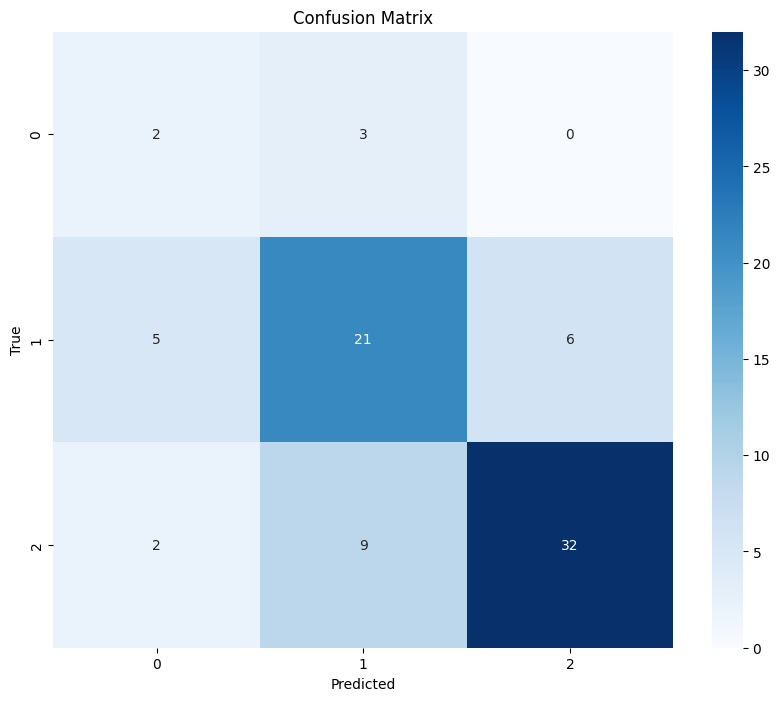

In [8]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Plot confusion matrix 
if task == "classification":
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            out = model(batch)
            preds = out.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch.y.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
